In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import clear_output
import numpy as np
import random
import time
from collections import deque
import heapq
import itertools

rows, cols = 20, 20

color_map = {
    'WHITE': 0,
    'BLACK': 1,
    'GREEN': 2,
    'RED': 3,
    'BLUE': 4,
    'LIGHT_BLUE': 5,
    'YELLOW': 6,
    'DARK_RED': 7
}

cmap = ListedColormap([
    '#eeeeee',
    '#000000',
    '#00ff00',
    '#ff0000',
    '#0000ff',
    '#add8e6',
    '#ffff00',
    '#8b0000'
])

DIRS = [
    (0, -1), (1, -1), (1, 0), (1, 1),
    (0, 1), (-1, 1), (-1, 0), (-1, -1)
]

class Node:
    def __init__(self, row, col):
        self.row = row
        self.col = col
        self.color = 'WHITE'


def draw_grid_jupyter(grid, title="GOOD PERFORMANCE TIME APP", delay=0.05):
    matrix = np.zeros((rows, cols))

    for r in range(rows):
        for c in range(cols):
            matrix[r][c] = color_map[grid[r][c].color]

    clear_output(wait=True)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(matrix, cmap=cmap, vmin=0, vmax=7)

    ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)

    ax.tick_params(which="minor", size=0)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_title(title)
    plt.show()

    time.sleep(delay)


def get_neighbors(grid, node):
    neighbors = []

    for dx, dy in DIRS:
        r = node.row + dy
        c = node.col + dx

        if 0 <= r < rows and 0 <= c < cols:
            if grid[r][c].color not in ['BLACK', 'DARK_RED']:
                neighbors.append(grid[r][c])

    return neighbors

def reset_search_colors(grid, start, target):
    for row in grid:
        for node in row:
            if node.color in ['BLUE', 'LIGHT_BLUE', 'YELLOW']:
                node.color = 'WHITE'

    start.color = 'GREEN'
    target.color = 'RED'


In [2]:
def bfs(grid, start, goal):
    visited = {start}
    queue = deque([[start]])

    while queue:
        path = queue.popleft()
        node = path[-1]

        if node == goal:
            return path

        for neighbor in get_neighbors(grid, node):
            if neighbor not in visited:
                visited.add(neighbor)
                if neighbor != goal:
                    neighbor.color = 'BLUE'
                queue.append(path + [neighbor])

        if node != start:
            node.color = 'LIGHT_BLUE'

        draw_grid_jupyter(grid, "BFS Searching...")

    return []


def dfs(grid, start, goal):
    stack = [[start]]
    visited = set()

    while stack:
        path = stack.pop()
        node = path[-1]

        if node == goal:
            return path

        if node not in visited:
            visited.add(node)

            if node != start and node != goal:
                node.color = 'LIGHT_BLUE'

            for neighbor in reversed(get_neighbors(grid, node)):
                if neighbor not in visited:
                    if neighbor != goal:
                        neighbor.color = 'BLUE'
                    stack.append(path + [neighbor])

            draw_grid_jupyter(grid, "DFS Searching...")

    return []


def ucs(grid, start, goal):
    counter = itertools.count()
    pri_q = [(0, next(counter), start, [start])]
    visited = set()

    while pri_q:
        cost, _, node, path = heapq.heappop(pri_q)

        if node == goal:
            return path

        if node in visited:
            continue

        visited.add(node)

        if node != start:
            node.color = 'LIGHT_BLUE'

        for nbr in get_neighbors(grid, node):
            if nbr not in visited:
                if nbr != goal:
                    nbr.color = 'BLUE'
                heapq.heappush(
                    pri_q,
                    (cost + 1, next(counter), nbr, path + [nbr])
                )

        draw_grid_jupyter(grid, "UCS Searching...")

    return []


def dls(grid, start, goal, limit):
    stack = [([start], 0)]
    visited_depths = {start: 0}

    while stack:
        path, depth = stack.pop()
        node = path[-1]

        if node == goal:
            return path

        if depth < limit:
            if node != start:
                node.color = 'LIGHT_BLUE'

            for nbr in reversed(get_neighbors(grid, node)):
                if nbr not in visited_depths or visited_depths[nbr] > depth + 1:
                    visited_depths[nbr] = depth + 1
                    if nbr != goal:
                        nbr.color = 'BLUE'
                    stack.append((path + [nbr], depth + 1))

        draw_grid_jupyter(
            grid,
            f"DLS Searching... (Depth Limit: {limit})"
        )

    return []


def iddfs(grid, start, goal):
    max_depth = rows * cols

    for depth in range(max_depth):
        reset_search_colors(grid, start, goal)

        path = dls(grid, start, goal, depth)
        if path:
            return path
    return []

def bidirectional_bfs(grid, start, goal):
    q1, q2 = deque([start]), deque([goal])
    vis1, vis2 = {start}, {goal}
    parent1, parent2 = {start: None}, {goal: None}

    def build_path(meet, p1, p2):
        path1, curr = [], meet

        while curr:
            path1.append(curr)
            curr = p1[curr]

        path1.reverse()

        path2, curr = [], p2[meet]

        while curr:
            path2.append(curr)
            curr = p2[curr]

        return path1 + path2

    while q1 and q2:
        node1 = q1.popleft()

        if node1 != start:
            node1.color = 'LIGHT_BLUE'

        for nbr in get_neighbors(grid, node1):
            if nbr not in vis1:
                vis1.add(nbr)
                parent1[nbr] = node1

                if nbr not in [start, goal]:
                    nbr.color = 'BLUE'

                q1.append(nbr)

                if nbr in vis2:
                    return build_path(nbr, parent1, parent2)

        node2 = q2.popleft()

        if node2 != goal:
            node2.color = 'LIGHT_BLUE'

        for nbr in get_neighbors(grid, node2):
            if nbr not in vis2:
                vis2.add(nbr)
                parent2[nbr] = node2

                if nbr not in [start, goal]:
                    nbr.color = 'BLUE'

                q2.append(nbr)

                if nbr in vis1:
                    return build_path(nbr, parent1, parent2)

        draw_grid_jupyter(grid, "Bidirectional BFS Searching...")

    return []

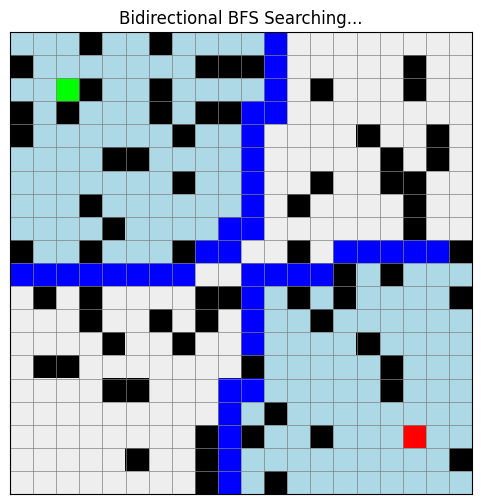

In [ ]:
grid = [[Node(r, c) for c in range(cols)] for r in range(rows)]

start = grid[2][2]
target = grid[rows - 3][cols - 3]

start.color = 'GREEN'
target.color = 'RED'
limit=10

for _ in range(75):
    r = random.randint(0, rows - 1)
    c = random.randint(0, cols - 1)

    if grid[r][c] not in [start, target]:
        grid[r][c].color = 'BLACK'


reset_search_colors(grid, start, target)
final_path = bidirectional_bfs(grid, start, target)


if final_path:
    for node in final_path:
        if node not in [start, target]:
            node.color = 'YELLOW'
    draw_grid_jupyter(
        grid,
        "GOOD PERFORMANCE TIME APP - Path Found!",
        delay=1.0
    )

    agent_pos = start

    while final_path:
        if random.random() < 0.05:
            r = random.randint(0, rows - 1)
            c = random.randint(0, cols - 1)
            obs = grid[r][c]

            if obs.color == 'WHITE':
                obs.color = 'DARK_RED'

                if obs in final_path:
                    draw_grid_jupyter(
                        grid,
                        "PATH BLOCKED! Replanning...",
                        delay=1.0
                    )

                    reset_search_colors(grid, agent_pos, target)
                    final_path = bfs(grid, agent_pos, target)
                    if not final_path:
                        print("Target unreachable!")
                        break

        next_node = final_path.pop(0)

        agent_pos.color = 'LIGHT_BLUE'
        agent_pos = next_node
        agent_pos.color = 'GREEN'

        draw_grid_jupyter(
            grid,
            "Moving to Target...",
            delay=0.1
        )
else:
    print("No path found.")